# Sprint 15 - Computer Vision

## Project Overview

### Project Description

**The supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage.** You are asked to conduct that evaluation, so as you set to work, keep the following in mind:

The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
 - Computer vision methods can be used to determine age of a person from a photo
 
**The task then is to build and evaluate a model for verifying people's age.** To start working on the task, you'll have a set of photographs of people with their ages indicated.

### Project Instructions

- Perform exploratory data analysis to get an overall impression of the dataset.
- Train and evaluate the model (it needs to be done on the GPU platform).
- Combine your code, output and findings (from the previous points) in the final Jupyter notebook.
- Make conclusions of the model evaluation, add them to the notebook.
- Project reviewers will review your final notebook.

## Initialization

### Import Libraries & Make Configurations for Analysis

In [1]:
# Import libraries required for this analysis
import numpy as np
import pandas as pd

# For displying images 
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Load Data
### Data Description

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
# Read in data csv and convert to dataframe
labels = pd.read_csv('/datasets/faces/labels.csv')

# ImageDataGenerator class forms batches with images and class labels based on the photos in the folders
# When rescale is set to a value, rescaling is applied to sample data before computing the internal data stats.
train_datagen = ImageDataGenerator(rescale=1./255)

# Extract data 
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224), # the target image size - target width and height of the image. The folders may contain images of different sizes, but the neural networks need all images to have the same dimensions.
        batch_size=32, # the number of images in the batches. The more images there are, the more effective the model's training will be.
        class_mode='raw', #an argument that indicates the class label output mode.
        seed=12345 # set a random number generator
) 

Found 7591 validated image filenames.


## EDA
In this section, we will take a look at the labels and an output a sample of images

### Descriptive Stats

In [3]:
# Use print so I don't lose outputs

# Check for missing values
print('Check for Missing Values')
print(labels.isna().sum())
print()


# Check values for each column
print('Describe Dataframe')
print(labels.describe())
print()

# Check data types
print('Check Data Types')
print(labels.info())
print()

# Check for Duplicates
print('Count of Duplicated Rows')
print(labels.duplicated().sum())
print()

Check for Missing Values
file_name    0
real_age     0
dtype: int64

Describe Dataframe
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

Check Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None

Count of Duplicated Rows
0



**_Findings -_** Below are some quick findings about the labels dataframe
 - `labels.csv` file with labels, with two columns: `file_name` and `real_age`
 - There are no missing values or duplicate files
 - The mean real age is 31 and the median is 29 years old. There is a standard deviation of 17. This means that there are people in this dataset that are in their teens and should not be able to buy alcohol - under 21 years old

### Plot Real Age Distribution

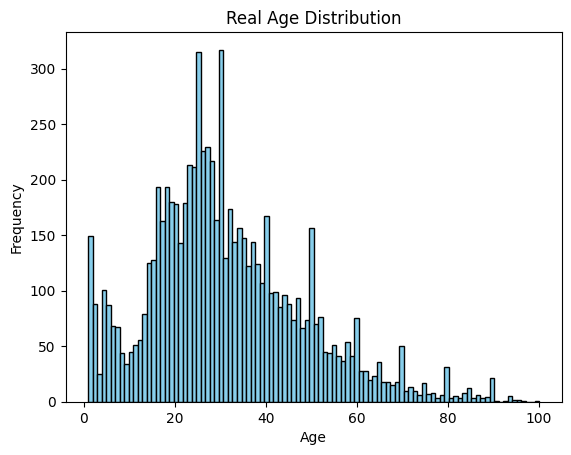

In [4]:
# Plotting a basic histogram
# Use 100 bins because the max value for age in the dataset is 100
plt.hist(labels['real_age'], bins = 100, color='skyblue', edgecolor='black')
 
# Adding labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Real Age Distribution')

# Display the plot
plt.show()

### Count of Underage People

In [5]:
# Calculate all users in dataset and users that are under the age of 21
underage = len(labels[labels['real_age'] < 21]['real_age'])
all_users = len(labels['real_age'])

# Print stats
print('There are', underage, 'people in the dataset out of',all_users,'people')
print('This represents',round(underage/all_users,2),'of the dataset' )

There are 2054 people in the dataset out of 7591 people
This represents 0.27 of the dataset


### Display Sample of Images

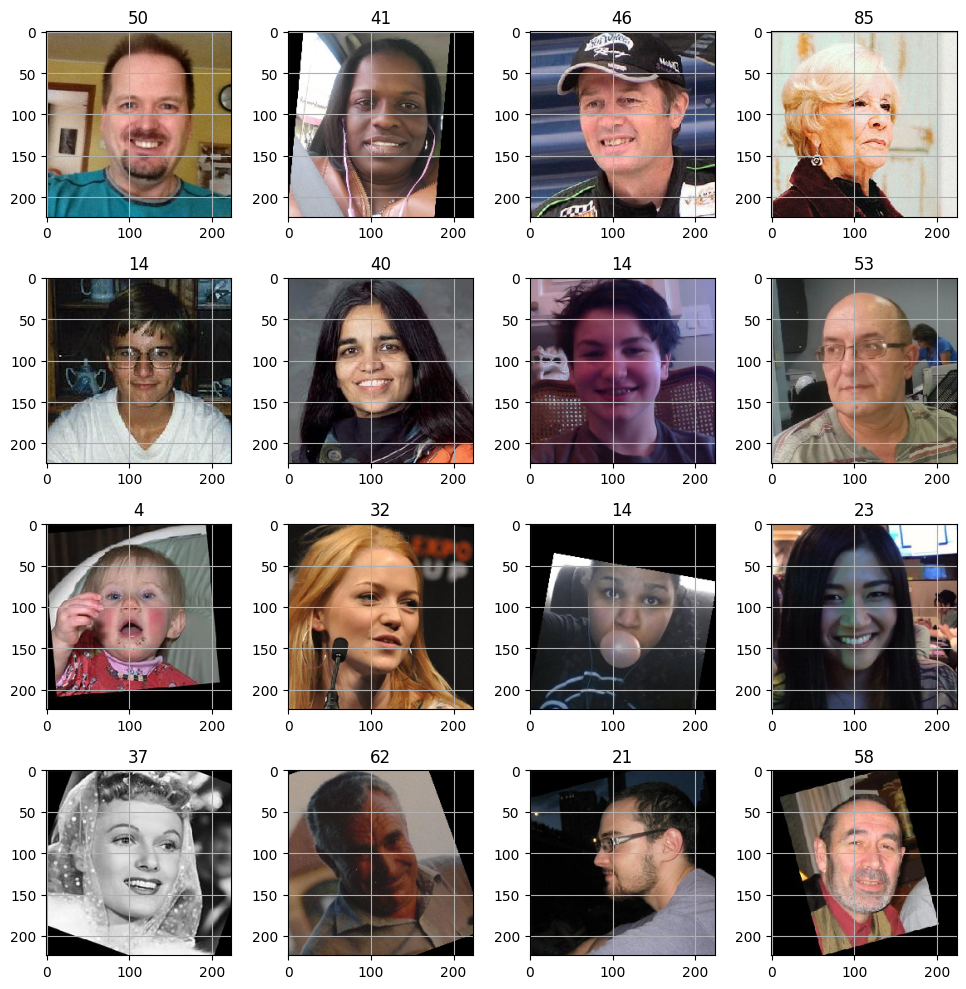

In [6]:
# Display the images from the first batch in the training set
# Taken from Sprint 15 Chapter 9 - Augmentations in Keras
features, target = next(train_gen_flow)

# Plot 4 x 4 grid of images with grid and real age per image
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.imshow(features[i])
    plt.title(target[i])
    plt.grid(True)
    plt.tight_layout()

### Findings

**_Findings -_** Below are some findings about provided data sets
 - `labels.csv` file with labels, with two columns: `file_name` and `real_age`
 - There are no missing values or duplicate files
 - The mean real age is 31 and the median is 29 years old. There is a standard deviation of 17. This means that there are people in this dataset that are in their teens and should not be able to buy alcohol. 
 - The histogram also proves that there are are people in the dataset that are underage and shouldn't be able to purchase alcohol.
 - 27% of people in the dataset are under the age of 21
 - When pulling a sample of images, there is a wide range of angles, quality, genders, and other attributes that will make determining age a difficult task. 
 - Since we are determining age, this will be a regression task

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [7]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    
    """
    
    # Taken from Sprint 15 Chapter 9 - Augmentations in Keras and reworked for this project
    train_datagen = ImageDataGenerator(
                    validation_split=0.25,
                    rescale=1./255,
                    horizontal_flip=True,
                    vertical_flip=True,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    rotation_range=90
                    ) 
     
    train_gen_flow = train_datagen.flow_from_dataframe(
                        dataframe=labels,
                        directory='/datasets/faces/final_files/',
                        x_col='file_name',
                        y_col='real_age',
                        target_size=(150, 150), #As set in ResNet in Keras Chapter
                        batch_size=32, # the number of images in the batches. The more images there are, the more effective the model's training will be.
                        class_mode='raw', #an argument that indicates the class label output mode.
                        subset='training',
                        seed=12345 # set a random number generator
                        ) 

    return train_gen_flow

In [8]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    # Taken from Sprint 15 Chapter 9 - Augmentations in Keras and reworked for this project
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1./255)
        
    test_gen_flow = train_datagen.flow_from_dataframe(
                            dataframe=labels,
                            directory='/datasets/faces/final_files/',
                            x_col='file_name',
                            y_col='real_age',
                            target_size=(150, 150), #As set in ResNet in Keras Chapter
                            batch_size=32, # the number of images in the batches. The more images there are, the more effective the model's training will be.
                            class_mode='raw', #an argument that indicates the class label output mode.
                            subset='validation',
                            seed=12345 # set a random number generator
                            ) 

    return test_gen_flow

In [9]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    # From Sprint 15 - ResNet in Keras Chapter
    backbone = ResNet50(
    input_shape=(150, 150, 3), weights='imagenet', include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu'))
    
    # From Sprint 15 - ResNet in Keras Chapter
    # Set learning rate is 0.01 
    optimizer = Adam(lr=0.01)

    model.compile(
    optimizer=optimizer, 
    loss='mse',
    metrics=['mae']
    )

    return model

In [10]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    # Comes from Sprint 15 - Multilayer Network Training
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [11]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

`
Epoch 1/20 
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921
Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035
Epoch 3/20
356/356 - 35s - loss: 69.9428 - mae: 6.3992 - val_loss: 91.1531 - val_mae: 7.4454
Epoch 4/20
356/356 - 35s - loss: 64.4249 - mae: 6.1407 - val_loss: 124.0287 - val_mae: 8.3481
Epoch 5/20
356/356 - 35s - loss: 52.8486 - mae: 5.5913 - val_loss: 109.1004 - val_mae: 8.2192
Epoch 6/20
356/356 - 35s - loss: 46.3094 - mae: 5.2223 - val_loss: 85.1038 - val_mae: 7.0332
Epoch 7/20
356/356 - 35s - loss: 38.2617 - mae: 4.7951 - val_loss: 92.0900 - val_mae: 7.3359
Epoch 8/20
356/356 - 35s - loss: 37.4804 - mae: 4.7402 - val_loss: 80.0016 - val_mae: 6.7239
Epoch 9/20
356/356 - 35s - loss: 33.5237 - mae: 4.4271 - val_loss: 83.2579 - val_mae: 6.8529
Epoch 10/20
356/356 - 35s - loss: 28.5170 - mae: 4.1411 - val_loss: 83.5056 - val_mae: 6.9629
Epoch 11/20
356/356 - 35s - loss: 27.0142 - mae: 3.9700 - val_loss: 92.1290 - val_mae: 7.1866
Epoch 12/20
356/356 - 35s - loss: 27.4564 - mae: 4.0428 - val_loss: 185.6307 - val_mae: 11.4591
Epoch 13/20
356/356 - 35s - loss: 23.7961 - mae: 3.7407 - val_loss: 92.3429 - val_mae: 7.2467
Epoch 14/20
356/356 - 35s - loss: 24.6167 - mae: 3.8116 - val_loss: 92.4542 - val_mae: 7.1401
Epoch 15/20
356/356 - 35s - loss: 22.2604 - mae: 3.6746 - val_loss: 82.5822 - val_mae: 6.7841
Epoch 16/20
356/356 - 35s - loss: 20.1899 - mae: 3.4430 - val_loss: 86.3830 - val_mae: 6.8304
Epoch 17/20
356/356 - 35s - loss: 17.3425 - mae: 3.2205 - val_loss: 78.4369 - val_mae: 6.6419
Epoch 18/20
356/356 - 35s - loss: 16.5249 - mae: 3.1295 - val_loss: 81.7731 - val_mae: 6.7226
Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908
Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512 
`

## Conclusions

**Recall that the supermarket chain Good Seed would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage.** I was asked to conduct that evaluation. The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol. Using a sample of photos of people, I built a computer vision model that can predict a person's age. 

To complete this project, I used a ResNet50 neural network to predict a person's age by using facial images and evaluated model performance through the use of a mean average error (MAE) loss function. The requirement for this project was that the MAE score not be higher than 8, and I found my model to have a MAE of 7.65. While the model meets the acceptance criteria, the best indicator of where a person is of age to purchase alcohol would be there drivers license. Checking a drivers license would produce much better results than implementing a model that may or may not accurately predict a user's age each time which may have unitended consequences for Good Seed. 